# Global Forecasting System - Meteorological forecast

In [1]:
import xarray
import numpy as np
import pandas as pd
import mikeio

The file `gfs_wind.nc` contains a small sample of the [GFS](https://nomads.ncep.noaa.gov/) forecast data downloaded via their OpenDAP service

In [2]:
ds = xarray.open_dataset('../tests/testdata/gfs_wind.nc')

Running a Mike 21 HD model, needs at least three variables of meteorological forcing
* Mean Sea Level Pressure
* U 10m
* V 10m

In [3]:
ds.msletmsl

<xarray.DataArray 'msletmsl' (time: 3, lat: 41, lon: 21)>
array([[[101116.35 , 101134.555, ..., 101474.15 , 101485.35 ],
        [101122.95 , 101141.75 , ..., 101498.35 , 101509.15 ],
        ...,
        [101972.555, 102048.35 , ..., 101975.15 , 101966.15 ],
        [102029.555, 102074.95 , ..., 101970.75 , 101953.15 ]],

       [[100923.02 , 100932.43 , ..., 101305.43 , 101316.43 ],
        [100940.625, 100945.625, ..., 101329.83 , 101343.625],
        ...,
        [101875.43 , 101861.83 , ..., 101870.83 , 101875.83 ],
        [101912.43 , 101898.02 , ..., 101860.83 , 101876.83 ]],

       [[101001.36 , 101014.555, ..., 101453.76 , 101465.555],
        [101002.96 , 101017.96 , ..., 101513.36 , 101522.76 ],
        ...,
        [101853.36 , 101859.16 , ..., 101855.555, 101863.555],
        [101870.36 , 101869.96 , ..., 101866.36 , 101870.96 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2021-09-02T12:00:00 ... 2021-09-02T18:00:00
  * lat      (lat) float64 30.0 30.25 30.5 30.75 31.0 ... 39.25 39.5 39.75 40.0
  * lon      (lon) float64 10.0 10.25 10.5 10.75 11.0 ... 14.25 14.5 14.75 15.0
Attributes:
    long_name:  ** mean sea level mslp (eta model reduction) [pa]

In [4]:
ds.ugrd10m

<xarray.DataArray 'ugrd10m' (time: 3, lat: 41, lon: 21)>
array([[[ 1.021836,  1.151836, ..., -4.318164, -4.228164],
        [ 1.731836,  1.361836, ..., -4.408164, -4.138164],
        ...,
        [-2.328164, -0.578164, ...,  0.111836,  1.381836],
        [-1.368164, -0.248164, ...,  2.521836,  3.361836]],

       [[-1.186663, -0.896663, ..., -4.376663, -4.216662],
        [-0.516663, -0.106663, ..., -4.476663, -4.386662],
        ...,
        [-2.176662, -3.376662, ...,  2.673337,  3.193337],
        [-1.596663, -2.376662, ...,  2.923337,  3.493337]],

       [[-3.289988, -3.199988, ..., -5.399988, -5.479988],
        [-3.449988, -3.719988, ..., -7.419988, -6.809988],
        ...,
        [-2.629988, -3.189988, ...,  2.280012,  2.160012],
        [-1.719988, -2.939988, ...,  2.620012,  2.800012]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2021-09-02T12:00:00 ... 2021-09-02T18:00:00
  * lat      (lat) float64 30.0 30.25 30.5 30.75 31.0 ... 39.25 39.5 39.75 40.0
  * lon      (lon) float64 10.0 10.25 10.5 10.75 11.0 ... 14.25 14.5 14.75 15.0
Attributes:
    long_name:  ** 10 m above ground u-component of wind [m/s]

In [5]:
ds.vgrd10m

<xarray.DataArray 'vgrd10m' (time: 3, lat: 41, lon: 21)>
array([[[-0.474941, -0.634941, ..., -1.244941, -1.254941],
        [-1.124941, -0.504941, ..., -1.014941, -1.224941],
        ...,
        [-0.454941,  1.145059, ...,  1.505059,  1.635059],
        [ 1.695059,  2.595058, ...,  1.645059,  1.805059]],

       [[-4.673393, -3.993393, ..., -2.993393, -3.323394],
        [-4.393394, -4.633393, ..., -2.723393, -3.213393],
        ...,
        [-0.593394,  0.456606, ...,  0.616606, -0.323394],
        [ 0.046606,  1.156606, ...,  0.066606, -1.213394]],

       [[-2.777568, -3.487568, ..., -4.187568, -4.807568],
        [-1.427568, -1.767568, ..., -5.827568, -6.177568],
        ...,
        [-1.707568, -1.177568, ..., -2.307568, -2.357568],
        [-2.577568, -1.327568, ..., -2.947568, -3.897568]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2021-09-02T12:00:00 ... 2021-09-02T18:00:00
  * lat      (lat) float64 30.0 30.25 30.5 30.75 31.0 ... 39.25 39.5 39.75 40.0
  * lon      (lon) float64 10.0 10.25 10.5 10.75 11.0 ... 14.25 14.5 14.75 15.0
Attributes:
    long_name:  ** 10 m above ground v-component of wind [m/s]

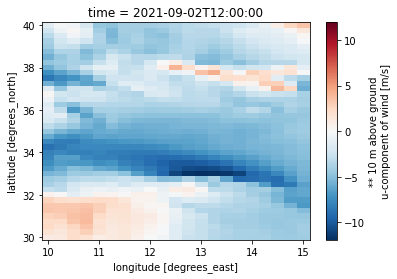

In [6]:
ds.ugrd10m[0].plot()

## Convert to dfs2

## Time

In [7]:
time = pd.DatetimeIndex(ds.time)
time

DatetimeIndex(['2021-09-02 12:00:00', '2021-09-02 15:00:00',
               '2021-09-02 18:00:00'],
              dtype='datetime64[ns]', freq=None)

## Variable types

In [8]:
mikeio.EUMType.Air_Pressure

Air Pressure

In [9]:
mikeio.EUMType.Air_Pressure.units

[hectopascal, millibar]

In [10]:
mikeio.EUMType.Wind_Velocity

Wind Velocity

In [11]:
mikeio.EUMType.Wind_Velocity.units

[meter per sec, feet per sec, miles per hour, km per hour, knot]

In [12]:
mslp = ds.msletmsl.values / 100 # conversion from Pa to hPa
u = ds.ugrd10m.values
v = ds.vgrd10m.values

In [13]:
geometry = mikeio.Grid2D(x=ds.lon.values, y=ds.lat.values, projection="LONG/LAT")
geometry

<mikeio.Grid2D>
x-axis: nx=21 points from x0=10 to x1=15 with dx=0.25
y-axis: ny=41 points from y0=30 to y1=40 with dy=0.25
Number of grid points: 861

In [14]:
from mikeio import ItemInfo, EUMType, EUMUnit

mslp_da = mikeio.DataArray(data=mslp,time=time, geometry=geometry, item=ItemInfo("Mean Sea Level Pressure", EUMType.Air_Pressure, EUMUnit.hectopascal))
u_da = mikeio.DataArray(data=u,time=time, geometry=geometry, item=ItemInfo("Wind U", EUMType.Wind_Velocity, EUMUnit.meter_per_sec))
v_da = mikeio.DataArray(data=v,time=time, geometry=geometry, item=ItemInfo("WTF?", EUMType.Wind_Velocity, EUMUnit.meter_per_sec))

In [15]:
mds = mikeio.Dataset([mslp_da, u_da, v_da])
mds

<mikeio.Dataset>
Dimensions: (time:3, y:41, x:21)
Time: 2021-09-02 12:00:00 - 2021-09-02 18:00:00 (3 records)
Items:
  0:  Mean Sea Level Pressure <Air Pressure> (hectopascal)
  1:  Wind U <Wind Velocity> (meter per sec)
  2:  WTF? <Wind Velocity> (meter per sec)

In [16]:
mds.to_dfs("gfs.dfs2")

## Clean up (don't run this)

In [17]:
import os
os.remove("gfs.dfs2")